# TMDB Movies Exploratory Analysis





In [48]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

print('Imports complete')

Imports complete


## 2. Load datasets

In [49]:
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

print('movies shape:', movies.shape)
print('credits shape:', credits.shape)

movies.head(2)

movies shape: (4803, 20)
credits shape: (4803, 4)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 878, ""name"": ""Science Fiction""}]",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""space war""}, {""id"": 3388, ""name"": ""space colony""}, {""id"": 3679, ""name"": ""society""}, {""id"": 3801, ""name"": ""space travel""}, {""id"": 9685, ""name"": ""futuristic""}, {""id"": 9840, ""name"": ""romance""}, {""id"": 9882, ""name"": ""space""}, {""id"": 9951, ""name"": ""alien""}, {""id"": 10148, ""name"": ""tribe""}, {""id"": 10158, ""na...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporation"", ""id"": 306}, {""name"": ""Dune Entertainment"", ""id"": 444}, {""name"": ""Lightstorm Entertainment"", ""id"": 574}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic island""}, {""id"": 1319, ""name"": ""east india trading company""}, {""id"": 2038, ""name"": ""love of one's life""}, {""id"": 2052, ""name"": ""traitor""}, {""id"": 2580, ""name"": ""shipwreck""}, {""id"": 2660, ""name"": ""strong woman""}, {""id"": 3799, ""name"": ""ship""}, {""id"": 5740, ""name"": ""alliance""}, {""id"": 5941, ""name"": ""caly...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of the Earth with Will Turner and Elizabeth Swann. But nothing is quite as it seems.",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""name"": ""Second Mate Productions"", ""id"": 19936}]","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


## 3. Data inspection

In [50]:
print('\nMovies info:')
print(movies.info())
print('\nMissing values (movies):')
print(movies.isnull().sum())

print('\nCredits info:')
print(credits.info())
print('\nMissing values (credits):')
print(credits.isnull().sum())

print('\nDuplicates in movies by id:', movies['id'].duplicated().sum())
print('Duplicates in credits by movie_id:', credits['movie_id'].duplicated().sum())


Movies info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status 

## 4. Cleaning.

In [51]:
import ast

def parse_json_column(entry):
    if pd.isna(entry):
        return []
  
    try:
        parsed = ast.literal_eval(entry)
        if isinstance(parsed, list):
            return parsed
        else:
            return []
    except Exception:
        
        try:
            return json.loads(entry)
        except Exception:
            return []

for col in ['genres', 'production_companies', 'keywords']:
    if col in movies.columns:
        movies[col] = movies[col].apply(parse_json_column)

for col in ['cast', 'crew']:
    if col in credits.columns:
        credits[col] = credits[col].apply(parse_json_column)

for col in ['budget', 'revenue', 'runtime', 'popularity']:
    if col in movies.columns:
        movies[col] = pd.to_numeric(movies[col], errors='coerce')

movies['id'] = pd.to_numeric(movies['id'], errors='coerce')
credits['movie_id'] = pd.to_numeric(credits['movie_id'], errors='coerce')

df = movies.merge(credits, left_on='id', right_on='movie_id', how='left')

# --- FIX STARTS HERE ---
# Rename the 'title_x' column from the movies dataframe to 'title'
df.rename(columns={'title_x': 'title'}, inplace=True)
# Drop the redundant 'movie_id' and 'title_y' columns
df.drop(columns=['movie_id', 'title_y'], inplace=True)
# --- FIX ENDS HERE ---

print('Merged shape:', df.shape)

df[['id','title','budget','revenue','runtime']].head()

Merged shape: (4803, 22)


,id,title,budget,revenue,runtime
0,19995,Avatar,237000000,2787965087,162.0
1,285,Pirates of the Caribbean: At World's End,300000000,961000000,169.0
2,206647,Spectre,245000000,880674609,148.0
3,49026,The Dark Knight Rises,250000000,1084939099,165.0
4,49529,John Carter,260000000,284139100,132.0


In [52]:
for col in ['budget','revenue']:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

print('Non-null counts:')
print(df[['budget','revenue']].notnull().sum())

Non-null counts:
budget     3766
revenue    3376
dtype: int64


## 5. Feature extraction


In [53]:
def extract_names(list_of_dicts):
    return [d.get('name') for d in list_of_dicts if isinstance(d, dict) and 'name' in d]

if 'genres' in df.columns:
    df['genre_list'] = df['genres'].apply(extract_names)

if 'production_companies' in df.columns:
    df['prod_companies'] = df['production_companies'].apply(extract_names)

def get_director(crew_list):
    for mem in crew_list:
        if isinstance(mem, dict) and mem.get('job') == 'Director':
            return mem.get('name')
    return np.nan

if 'crew' in df.columns:
    df['director'] = df['crew'].apply(get_director)

if 'release_date' in df.columns:
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = df['release_date'].dt.year

if 'keywords' in df.columns:
    df['keyword_list'] = df['keywords'].apply(extract_names)

df[['title','genre_list','director','prod_companies','release_year']].head()

,title,genre_list,director,prod_companies,release_year
0,Avatar,"[Action, Adventure, Fantasy, Science Fiction]",James Cameron,"[Ingenious Film Partners, Twentieth Century Fox Film Corporation, Dune Entertainment, Lightstorm Entertainment]",2009.0
1,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]",Gore Verbinski,"[Walt Disney Pictures, Jerry Bruckheimer Films, Second Mate Productions]",2007.0
2,Spectre,"[Action, Adventure, Crime]",Sam Mendes,"[Columbia Pictures, Danjaq, B24]",2015.0
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",Christopher Nolan,"[Legendary Pictures, Warner Bros., DC Entertainment, Syncopy]",2012.0
4,John Carter,"[Action, Adventure, Science Fiction]",Andrew Stanton,[Walt Disney Pictures],2012.0


## 6. Exploratory Analysis & Visualizations

1. Which genres are the most common?
2. Who are the top 10 highest-grossing directors?
3. Is there a correlation between a movie's budget and its revenue? (scatter plot)
4. What is the average movie runtime? Has it changed over the years?
5. Which production companies have produced the most high-revenue films?

genre_list
Drama       2297
Comedy      1722
Thriller    1274
Action      1154
Romance      894
Name: count, dtype: int64


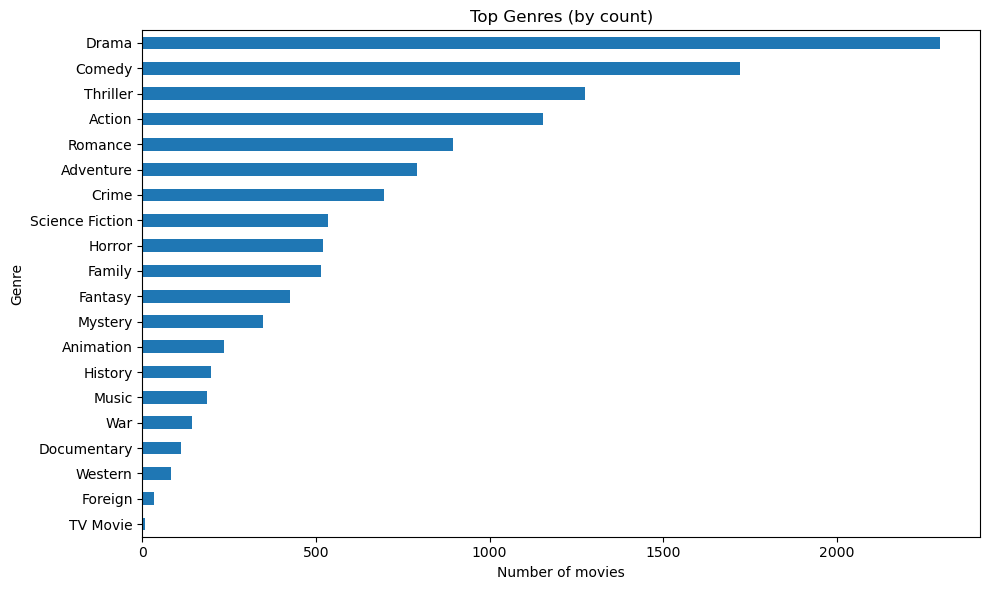

In [54]:
# Q1: Most common genres
all_genres = df['genre_list'].dropna().explode()
genre_counts = all_genres.value_counts().head(20)
print(genre_counts.head())

plt.figure(figsize=(10,6))
genre_counts.sort_values().plot.barh()
plt.title('Top Genres (by count)')
plt.xlabel('Number of movies')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

director
Steven Spielberg     9.147393e+09
Peter Jackson        6.498643e+09
James Cameron        5.883569e+09
Michael Bay          5.832525e+09
Christopher Nolan    4.227483e+09
Chris Columbus       3.725632e+09
Robert Zemeckis      3.590622e+09
George Lucas         3.339114e+09
Tim Burton           3.337418e+09
Ridley Scott         3.189558e+09
Name: revenue, dtype: float64


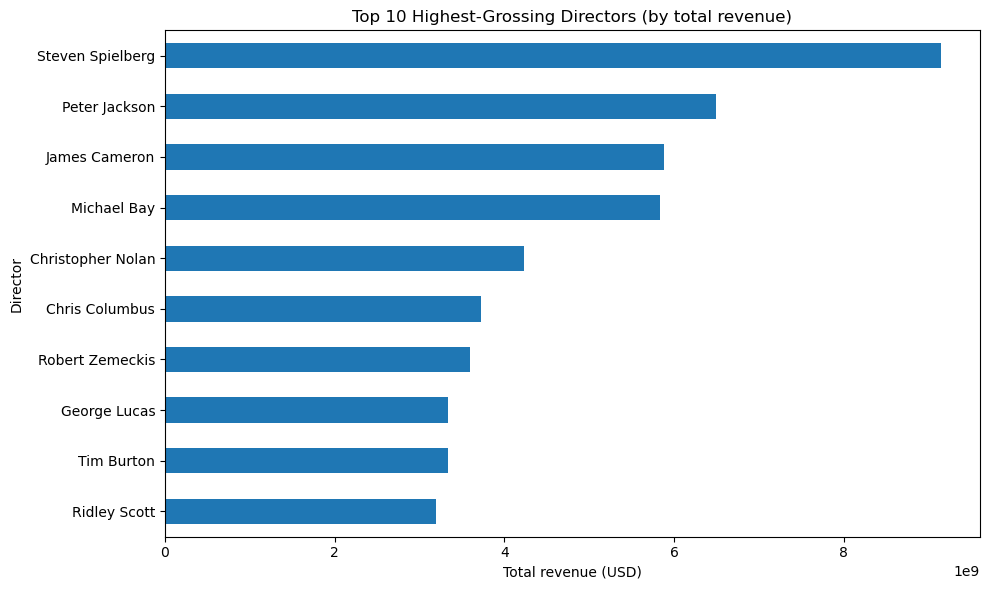

In [55]:
# Q2: Top 10 highest-grossing directors
director_rev = df.dropna(subset=['director','revenue']).groupby('director')['revenue'].sum().sort_values(ascending=False).head(10)
print(director_rev)

plt.figure(figsize=(10,6))
director_rev.sort_values().plot.barh()
plt.title('Top 10 Highest-Grossing Directors (by total revenue)')
plt.xlabel('Total revenue (USD)')
plt.ylabel('Director')
plt.tight_layout()
plt.show()

Samples for correlation: 3229
Pearson correlation between budget and revenue: 0.7054


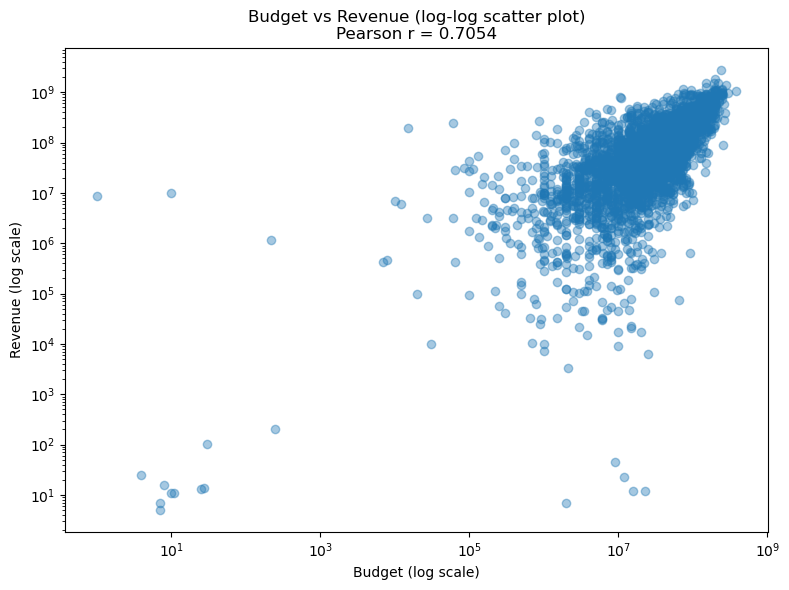

In [56]:
# Q3: Budget vs Revenue correlation
br = df.dropna(subset=['budget','revenue'])[['budget','revenue']].copy()
print('Samples for correlation:', br.shape[0])

corr = br['budget'].corr(br['revenue'])
print('Pearson correlation between budget and revenue: {:.4f}'.format(corr))

plt.figure(figsize=(8,6))
plt.scatter(br['budget'], br['revenue'], alpha=0.4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Budget (log scale)')
plt.ylabel('Revenue (log scale)')
plt.title('Budget vs Revenue (log-log scatter plot)\nPearson r = {:.4f}'.format(corr))
plt.tight_layout()
plt.show()

Years available: 1916.0 to 2017.0


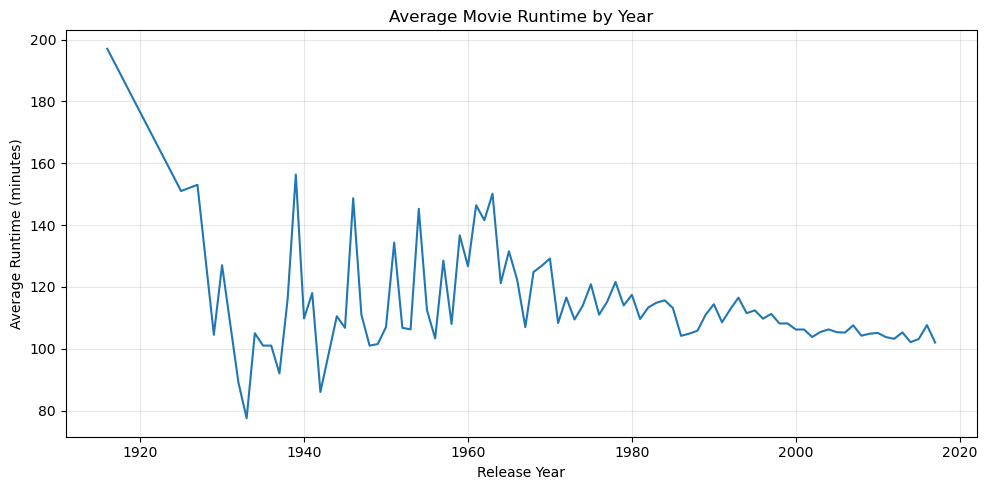

In [57]:
# Q4: Average runtime over the years
runtime_by_year = df.dropna(subset=['release_year','runtime']).groupby('release_year')['runtime'].mean()
print('Years available:', runtime_by_year.index.min(), 'to', runtime_by_year.index.max())

plt.figure(figsize=(10,5))
plt.plot(runtime_by_year.index, runtime_by_year.values)
plt.xlabel('Release Year')
plt.ylabel('Average Runtime (minutes)')
plt.title('Average Movie Runtime by Year')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

75th percentile revenue = 140165095.5
prod_companies
Warner Bros.                              110
Universal Pictures                        106
Twentieth Century Fox Film Corporation     92
Paramount Pictures                         91
Columbia Pictures                          70
Name: count, dtype: int64


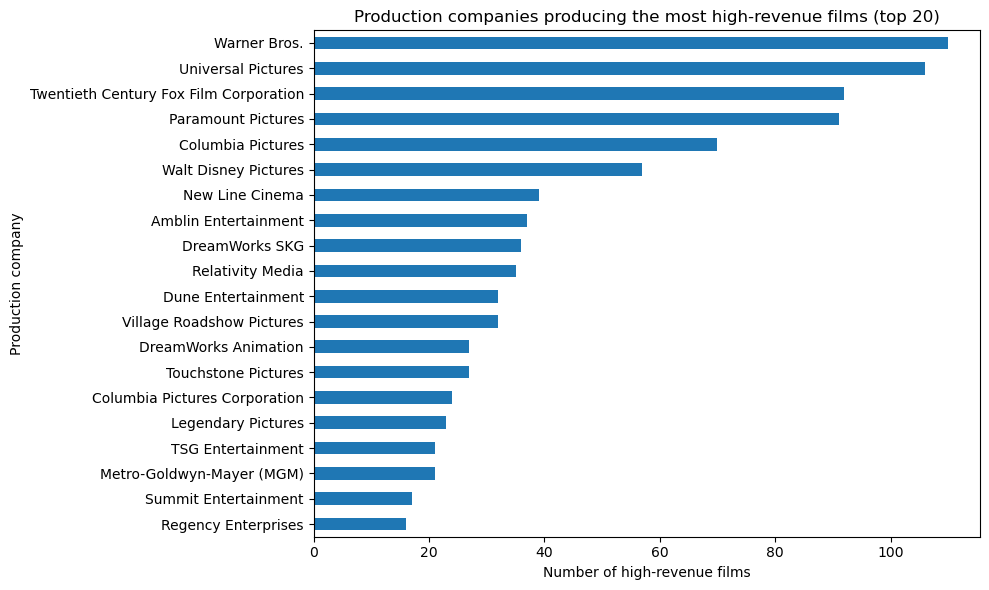

In [58]:
# Q5: Which production companies have produced the most high-revenue films?
rev_q75 = df['revenue'].dropna().quantile(0.75)
print('75th percentile revenue =', rev_q75)

high_rev = df[df['revenue'] >= rev_q75]

pc = high_rev['prod_companies'].dropna().explode()
pc_counts = pc.value_counts().head(20)
print(pc_counts.head())

plt.figure(figsize=(10,6))
pc_counts.sort_values().plot.barh()
plt.title('Production companies producing the most high-revenue films (top 20)')
plt.xlabel('Number of high-revenue films')
plt.ylabel('Production company')
plt.tight_layout()
plt.show()

keyword_list
woman director          324
independent film        318
duringcreditsstinger    307
based on novel          197
murder                  189
Name: count, dtype: int64


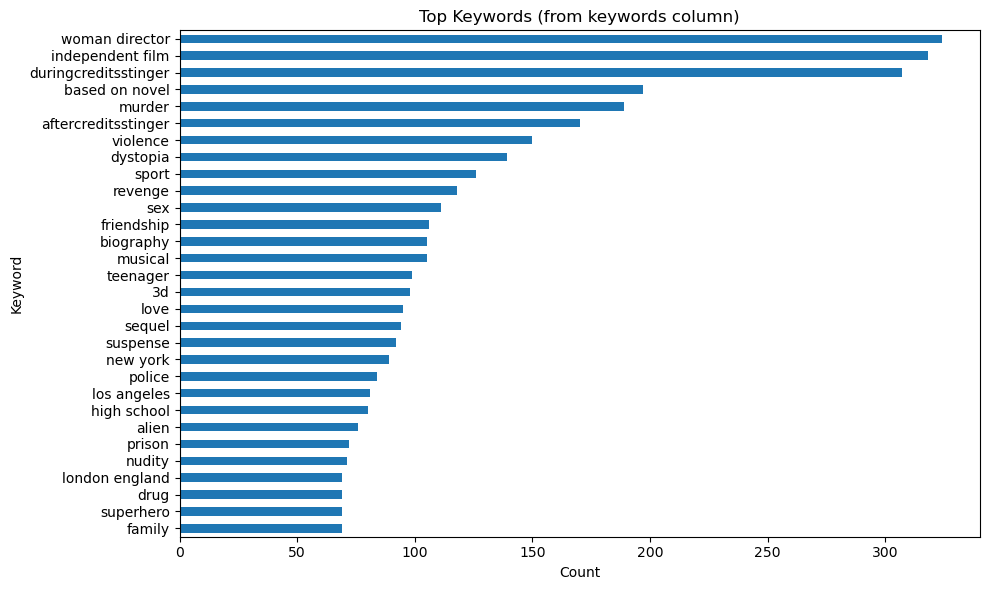

In [59]:
# Q6: Most frequent keywords in movie overviews/keywords field
if 'keyword_list' in df.columns:
    kw = df['keyword_list'].dropna().explode()
    kw_counts = kw.value_counts().head(30)
    print(kw_counts.head())
    plt.figure(figsize=(10,6))
    kw_counts.sort_values().plot.barh()
    plt.title('Top Keywords (from keywords column)')
    plt.xlabel('Count')
    plt.ylabel('Keyword')
    plt.tight_layout()
    plt.show()
else:
    print('No keywords column available.')